# 개요

일반적으로 순서는
1. Transformation 의 pandas 에서의 type 을 알맞게 지정하기
2. NA/outlier 를 처리하기 
3. 특성에 대해 categorical/ordinal/norminal 중에서 어떤것으로 정할것인지 정하고 변환하기
4. 기존의 변수를 조합해서 추가할것은 추가하기 (3과 같이진행됨)
5. Scailing 하기

- K-NN , SVM 은 distance 로 similarity 를 계산하기떄문에 scaling 에 매우 민감하다.
- xgboost , desciaion tree 같은 tree 기만 모델은 scaling 에 별 영향이 없다.
- gradient descent 를 이용한 모델은 scaling 에 영향이 있다. (NN)
- 하지만 모델을 하나만 쓸것도 아니고, 적절한 scaling 은 성능을 올려주므로 꼭 하는게 좋다.

- MinMaxScaler : Range가 규정된 경우 사용(RGB), Outlier가 없는 경우 사용
- StandardScaler : PCA시 사용
- Outliers : lower bound, upper bound를 선정해서 1~99% 데이터만 사용(clip)
- Rank transformation : <br>
    Outliear가 있다면 MinAxScaler보다 좋은 옵션<br>
    scipy.stats.rankdata로 사용<br>
    Test시에도 같은 rank value 적용
- Log transform : np.log(1+x), 정규화로 만들기 떄문에 매우 좋다.
- Raising to the power <1 : np.sqrt(x +2/3)
- 하나의 scaling만 사용하지 않고 여러 scaling을 사용해 feature로 추가할 경우 좋을 수 있음

- 일반적으로 distance를 이용하는 모델의 경우 (knn, svm) feature transformation 이 필요할것이다. (모든 feature 마다 비슷한 값을 가져야한다!)
- 다른 scaling 이 필요없는 모델들도, scaling 을 하면 성능이 개선되는 경우가 많으므로 꼭 해주는게 좋은것이다.

- 그리고 아래 예시와 같이, preprocessing 과정을 definition 으로 정의하는것이, 나중에 관리할때나 또 다른 set 이 왔을때에 새로 적용할때에 관리하기가 쉽다.

In [91]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
def convert_type(X):
    X['MSSubClass'] = X['MSSubClass'].apply(str)
    X['YrSold'] = X['YrSold'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)
convert_type(X_train)

In [23]:
def handle_missing(X):
    # the data description states that NA refers to typical ('Typ') values
    X['Functional'] = X['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    X['Electrical'] = X['Electrical'].fillna("SBrkr")
    X['KitchenQual'] = X['KitchenQual'].fillna("TA")
    X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
    X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])
    X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])
    X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    X["PoolQC"] = X["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        X[col] = X[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        X[col] = X[col].fillna('None')
    # NaN values for these categorical basement X, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        X[col] = X[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical X
    # So we replace their missing values with None
    objects = []
    for i in X.columns:
        if X[i].dtype == object:
            objects.append(i)
    X.update(X[objects].fillna('None'))
        
    # And we do the same thing for numerical X, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in X.columns:
        if X[i].dtype in numeric_dtypes:
            numeric.append(i)
    X.update(X[numeric].fillna(0))    
    return X

X_train = handle_missing(X_train)

- 데이터 준비 및 import

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
titanic = sns.load_dataset('titanic')
titanic.columns=titanic.columns.str.capitalize()
df = titanic.copy()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    int64   
 2   Sex          891 non-null    object  
 3   Age          714 non-null    float64 
 4   Sibsp        891 non-null    int64   
 5   Parch        891 non-null    int64   
 6   Fare         891 non-null    float64 
 7   Embarked     889 non-null    object  
 8   Class        891 non-null    category
 9   Who          891 non-null    object  
 10  Adult_male   891 non-null    bool    
 11  Deck         203 non-null    category
 12  Embark_town  889 non-null    object  
 13  Alive        891 non-null    object  
 14  Alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


# Transformation(pandas.Type)

적절히 type 변환을 하지 않게된다면, str 끼리 덧셈은 '3' + '4' = 34 처럼 왜곡되기 떄문에 꼭 해주어야하는 부분이다.

- ordinal 로 처리하고싶은 숫자형 변수가 있고, sklearn 의 label/ordinal encoding 을 쓰려는경우 -> str 으로 바꾼다. str 만 인식할수 있기 떄문
- 특성끼리 조합해서 새로운 특성을 만들고싶은 경우(ordinal인 경우에도) -> 꼭 int/float 형인지 확인해주자.
- 분석시에 numeric 으로 처리하고 싶은 경우 -> 꼭 float/int 로 값을 변환해주자. 가끔 str 으로 잡혀있는 경우가 있다.

pandas 의 DataFrame 에서는 많은 type 이 있다. 하지만 크게  <br>
- object : type 이 섞여있거나, str 일떄 
- int64, float64 : 데이터가 수치형일때 

- 수치형은 .astype(‘float’) 
- 문자형은 .astype(‘str’)
- 범주형은 .astype(‘category’) 으로 변화시켜주면 된다.

데이터 분석시에 ordinal 로 처리하고싶다면 우선 label incoder 로 categorical 변수 (poor / medium / good) -> (1,2,3) 등으로 숫자형으로 변환을 하여 분석한다.<br>
ordinal 은 그냥 numeric 으로 두고 처리할지(그러면 수 차이(poor 과 medium 은 1~2 만큼 차이가 난다!) 를 정당화해야되서 좀 어렵긴 하다.) 아니면 one hot 으로 하여 처리할지는 분석자의 마음대로이다. <br>

데이터 분석시에 categorical 로 처리하고 싶다면 데이터를 .astype('category') 로 해주어야 한다. .as('object') 는 정수형은 그래도 냅두는 등, 완벽히 변환시켜주지 않기 때문.

분석시에 numeric 으로 처리하고싶다면 astype('float') 을 해주어야 한다. 

In [40]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [41]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [42]:
titanic['pclass']=titanic['pclass'].astype('str') # 이러면 object 로 Type 이 바뀌게 된다.

## Object -> categorical

Categorical의 형태로 바꾸면 좋은점은 : As a signal to other Python libraries that this column should be treated as a categorical variable (e.g. to use suitable statistical methods or plot types). 이 있다. 또한 안에 숫자형,str 등이 섞인 object 형태일수 있기 떄문에 되도록이면 categorical 로 바꾸는것을 추천한다.


In [43]:
# 이러한 for 문이 도움이 될 것이다.
#for col in ['parks', 'playgrounds', 'sports', 'roading']:
#    data[col] = data[col].astype('category')

# Encoding(Type)

**[Label encoding]**
- Categorical data를 숫자로 변환
- sklearn.preprocessing.LabelEncoder와 Pandas.factorize로 가능
- 전자는 알파벳 순 또는 정렬된 순서로 인코딩 후자는 있는 그대로 인코딩
- 데이터마다 다르지만 factorize가 약 2배정도 빠름

**[Frequence Encoding]**
- 빈도별 인코딩
- Linear, Tree 모델 모두 도움이 될 수 있음
- Value의 빈도가 Target과 연관이 있으면 유용
- Encoding시 같은 빈도를 가지면 Feature로 추가하지 않아도 좋음

**[One-hot encoding]**
- Tree 모델에선 효율성이 떨어질 수 있음
- 컬럼이 많아져 학습이 힘들 수 있음(메모리 이슈)
- spare 매트릭스는 categorical data나 텍스트 데이터에서 종종 유용
- pandas.get_dummies, sklearn.preprocessing.OneHotEncoder

## value -> categorical(0,1)

In [44]:
from sklearn.preprocessing import Binarizer
scaler = Binarizer(threshold=2) # 2를 넘으면 1/미만이면
titanic[['pclass']] = scaler.fit_transform(titanic[['pclass']]) 
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,1.0,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,0.0,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,1.0,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,0.0,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,1.0,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.0,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,0.0,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,1.0,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,0.0,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## value(int) -> onehot

이 sklearn 의 onehotencoder 의 경우 수치형만 encding 이 가능해서, 먼저 label encoder를 해야한다.

In [45]:
titanic = sns.load_dataset("titanic")
from sklearn.preprocessing import OneHotEncoder
Encoder = OneHotEncoder() 
onehot = Encoder.fit_transform(titanic[['class']]).toarray() # toarray 로 해야 잘 array 로 변환된다.
pd.DataFrame(onehot,columns=['third','first','second']).head() 

,third,first,second
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


## value(conti) -> categorical

pd.qcut(df['Fare'],q=np.linspace(0,1,4), labels=['Low','Medium','High'])
- q(quantile) 만큼 cut 해서 label=[] 로 수치형을 범주형으로 변환한다

In [13]:
fare=pd.qcut(df['Fare'],q=np.linspace(0,1,4), labels=['Low','Medium','High'])
fare.head()

0     Low
1    High
2     Low
3    High
4     Low
Name: Fare, dtype: category
Categories (3, object): [Low < Medium < High]

In [14]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X = pd.DataFrame([['Male', 15],
                  ['Female',22],
                  ['Female',21]],columns=['sex','age'])
enc.fit(X[['sex']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [15]:
enc.categories_ # encoding 하게 될 데이터들이 들어있다.

[array(['Female', 'Male'], dtype=object)]

In [16]:
enc.transform([['Female'],['Male']])

array([[0.],
       [1.]])

## Categorical(descrete value)  -> ordinal(int)

categorical data 인 경우에는 str 으로 변환시켜주어야 Label 인코딩이 된다!(sklearn 의 변환기의 경우)<br>
즉, 숫자형의 categorical data (ex 태어난 년도) 의 경우 int 형으로 저장이 되어있을것 이므로 먼저 str 으로 변환시켜 주어야 한다.

LabelEncoder : 1개의 특성에 대해서만 가능하다. 그래서 별로 안씀... <br>
OrdialEndoder : X의 많은 특성에 대해서 한번에 적용이 가능하다!

encoder 시에 변환되는 categorical 의 0,1,2 순서는 알파벳 순서(또는 작은것부터 커지는 순서)이다. 이 순서를 임의로 변경할 수는 없다고 한다 ㅜㅜ<br>
그래서 한번에 ordinal 로 표현하고 싶다면 그런 경우는, 위 제목처럼 value 형을 가지는 경우에는 작으면 0 크면 점점 커지므로 한번에 변환이 가능하나, 그렇지 않은 경우는 일일히 해주어야한다.

In [17]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [18]:
from sklearn.preprocessing import OrdinalEncoder # 이건 Label encoder 로 불가능하다.
Encoder = OrdinalEncoder()
titanic[['class','alone']]=Encoder.fit_transform(titanic[['class','alone']])
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,2.0,man,True,NaN,Southampton,no,0.0
1,1,1,female,38.0,1,0,71.2833,C,0.0,woman,False,C,Cherbourg,yes,0.0
2,1,3,female,26.0,0,0,7.9250,S,2.0,woman,False,NaN,Southampton,yes,1.0
3,1,1,female,35.0,1,0,53.1000,S,0.0,woman,False,C,Southampton,yes,0.0
4,0,3,male,35.0,0,0,8.0500,S,2.0,man,True,NaN,Southampton,no,1.0


## Categorical -> Frequency(value) 

- Linear, Tree 모델 모두 도움이 될 수 있음
- Value의 빈도가 Target과 연관이 있으면 유용
- Encoding시 같은 빈도를 가지면 Feature로 추가하지 않아도 좋음


In [22]:
# size of each category
encoding = titanic.groupby('embarked').size()
# get frequency of each category
encoding = encoding/len(titanic)
titanic['enc'] = titanic.embarked.map(encoding)

# if categories have same frequency it can be an issue
# will need to change it to ranked frequency encoding
from scipy.stats import rankdata

In [23]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,enc
0,0,3,male,22.0,1,0,7.2500,S,2.0,man,True,NaN,Southampton,no,0.0,0.722783
1,1,1,female,38.0,1,0,71.2833,C,0.0,woman,False,C,Cherbourg,yes,0.0,0.188552
2,1,3,female,26.0,0,0,7.9250,S,2.0,woman,False,NaN,Southampton,yes,1.0,0.722783
3,1,1,female,35.0,1,0,53.1000,S,0.0,woman,False,C,Southampton,yes,0.0,0.722783
4,0,3,male,35.0,0,0,8.0500,S,2.0,man,True,NaN,Southampton,no,1.0,0.722783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,1.0,man,True,NaN,Southampton,no,1.0,0.722783
887,1,1,female,19.0,0,0,30.0000,S,0.0,woman,False,B,Southampton,yes,1.0,0.722783
888,0,3,female,NaN,1,2,23.4500,S,2.0,woman,False,NaN,Southampton,no,0.0,0.722783
889,1,1,male,26.0,0,0,30.0000,C,0.0,man,True,C,Cherbourg,yes,1.0,0.188552


## Categorical -> ordinal

사실 Categorical 에서 ordinal(poor , good , excellent!) -> (0,1,2) 처럼 변환을 하고싶을 것이다! 이 경우에는 sklearn 이 사실 알파벳순으로 0,1,2 를 매기기떄문에 우리가 직접 옆과같이 할당해 주려면 직접 def 해서 사용해야한다.

사실.... 이거 쓰는거도 좋지만 숫자가 0,1,2... 로 고정된다는 점에서 그냥 pd 로 노가다 변환을 하는게 더 선택지가 많기는 하다.

In [102]:
# 직접 변환기 만들기
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y): #fit 의 method ovewriting
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self

In [100]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [101]:
titanic['who'].value_counts()

man      537
woman    271
child     83
Name: who, dtype: int64

In [91]:
Encoder = MyLabelEncoder()
Encoder.fit(['child', 'woman','man']) # fit mathod 를 오버라이팅 해서, encoding 의 순서를 매기는 과정이 하나 더 늘어난것이다!
Encoder.classes_ # 와! 드디어 우리가 원하는 0,1,2 의 순서가 나온것을 볼 수 있다.
titanic[['who']]=Encoder.transform(titanic[['who']]) # 이떄에는 fit_trainsform 을 하면 위에서 정한 fit 을 쓰지 않게 되므로 transform 만 해주어야 한다.
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,2,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,1,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,1,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,1,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,2,True,NaN,Southampton,no,True


## categorical -> categorical

df.isin 은 범주형의 자료를 묶어서 표현할 때에 아주 요긴하다.<br>
예로, 설문지의 문항이 1~10 이고, 이중 2,4,5,7,8 을 묶어서 0 으로 범주화하고싶다면, 이 경우 논리연산자 (==,!=,&,| 등) 만으로는 해결하는데 에 무리가 있기 떄문이다.


In [7]:
df = titanic.copy()
df['Class']= df['Class'].astype('str')

df.loc[titanic['Class'].isin(['Third','Second']),'Class'] = '0'
df.loc[~titanic['Class'].isin(['Third','Second']),'Class'] = '1'
df.head()

,Survived,Pclass,Sex,Age,Sibsp,Parch,Fare,Embarked,Class,Who,Adult_male,Deck,Embark_town,Alive,Alone
0,0,3,male,22.0,1,0,7.2500,S,0,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,1,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,0,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,1,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,0,man,True,NaN,Southampton,no,True


## categorical -> onehot

pd.get_dummies(df, columns=['Pclass'],drop_first=True)
- columns = ['col'] : 더미면수로 바꾸고 싶은 col 을 입력. 여러개를 입력할 수도 있다.
    - 만약 설정하지 않는다면 object/categorical 의 데이터가 모두 변환된다.
- drop_first=True : 처음 더미변수를 drop 할지 (0,1,2 의 범주를 더미변수화 할 때 더미col 이 2개만 나온다. 1,2,3 -> (0,0) , (1,0), (0,1)
- 더미변수화가 되는 col 은 자동으로 삭제된다.

In [5]:
df = titanic.copy()
df = pd.get_dummies(df, columns=['Pclass'],drop_first=True)
df.head()

,Survived,Sex,Age,Sibsp,Parch,Fare,Embarked,Class,Who,Adult_male,Deck,Embark_town,Alive,Alone,Pclass_2,Pclass_3
0,0,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0,1
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0,0
2,1,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0,1
3,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0,0
4,0,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0,1


# Feature engineering

## Deleting uninformative data

- 쓸모없는 특성이 들어가있는 열이 있을것이다. 그 경우 삭제한다.
- 예를 들면 참가자의 id number, 학번 등이다.

## Deleting duplicated data

- 데이터가 중복될 수도 있다. 이 경우, 두 row 에 대해 unique 한 특성을 나타내는 값이 같다면 그건 중복된 데이터이므로 삭제한다.
- 예를 들어서, 학번/주민번호 등이 겹치는 경우는 무조건 duplicated 된 data 라고 볼 수 있다.
- 하지만 unique 한 x특성 이 없는 경우는 섣불리 삭제하지 말고 더 살펴봐야한다. 우연히 같을 수 있기 떄문.

## Combining data

- 특성을 조합해 쓸만한 특성을 만든다. (1층면적,2층면적.3층면적 의 특성을 다 더해 전체면적이라는 특성 만들기)
- 또는 아래와 같이 function 의 변환을 주어서 데이터 특성을 늘릴수도 있다.

### polynomial 

preprocessing 서브패키지는 데이터 변환을 위한 `FunctionTransformer` 클래스와 `PolynomialFeatures` 클래스도 제공한다.

`PolynomialFeatures` 클래스는 입력 데이터 $x$를 다음과 같이 여러개의 다항식으로 변환한다.

$$ x \;\; \rightarrow \;\; [ 1, x, x^2, x^3, \cdots ] $$

다음과 같은 입력 인수를 가진다.

* `degree` : 차수
* `include_bias` : 상수항 생성 여부


In [49]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

array([[ 1., -3.,  9.],
       [ 1., -2.,  4.],
       [ 1., -1.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.]])

### Custom function

`FunctionTransformer` 클래스는 사용자가 지정한 함수를 사용하여 입력값 $x$를 변환한다.

$$ x \;\; \rightarrow \;\; [ f_1(x),  f_2(x),  f_3(x),  \cdots ] $$

데이터 변환은 비선형 회귀분석에서 원하는 목표값을 더 잘 예측하기 위한 새로운 데이터를 만들 때 사용된다. 예를 들어 '360도'와 같은 각도 데이터는 그 자체로 예측문제의 입력값으로 넣을 수 없다. 0도와 360도, 10도와 370도는 사실 같은 각도지만 다른 숫자로 표현되기 때문이다. 이 때는 각도 $\theta$를 다음과 같이 삼각함수값의 쌍으로 바꾸면 같은 각도를 같은 숫자쌍으로 표현할 수 있다.

$$ \theta \;\; \rightarrow \;\; (\sin\theta, \cos\theta) $$

다음 예제 코드에서 원래 데이터 `X`는 각도 표시로 되어 있다. 

In [50]:
X = 90 * np.arange(9).reshape(-1, 1) 
X

array([[  0],
       [ 90],
       [180],
       [270],
       [360],
       [450],
       [540],
       [630],
       [720]])

하지만 `X2`는 삼각함수로 변환되었다. 각도 0도와 각도 360도가 모두 같은 값인 (0,1)로 표현된 것을 확인할 수 있다. 

In [51]:
from sklearn.preprocessing import FunctionTransformer

def degree2sincos(X):
    x0 = np.sin(X * np.pi / 180)
    x1 = np.cos(X * np.pi / 180)
    X_new = np.hstack([x0, x1])
    return X_new

X2 = FunctionTransformer(degree2sincos).fit_transform(X)
X2

array([[ 0.0000000e+00,  1.0000000e+00],
       [ 1.0000000e+00,  6.1232340e-17],
       [ 1.2246468e-16, -1.0000000e+00],
       [-1.0000000e+00, -1.8369702e-16],
       [-2.4492936e-16,  1.0000000e+00],
       [ 1.0000000e+00,  3.0616170e-16],
       [ 3.6739404e-16, -1.0000000e+00],
       [-1.0000000e+00, -4.2862638e-16],
       [-4.8985872e-16,  1.0000000e+00]])

# Scaling

## Scaling 방식

### standardize(): 평균을 0으로하고 표준편차를 1로 스케일링

평균을 제거하고 데이터를 단위 분산으로 조정한다. 그러나 이상치가 있다면 평균과 표준편차에 영향을 미쳐 변환된 데이터의 구조는 매우 달라지게 된다.
따라서 이상치가 있는 경우 균형 잡힌 척도를 보장할 수 없다.

In [47]:
X = np.arange(-3,5).reshape(-1, 1)  
X

array([[-3],
       [-2],
       [-1],
       [ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4]])

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X)

array([[-1.52752523],
       [-1.09108945],
       [-0.65465367],
       [-0.21821789],
       [ 0.21821789],
       [ 0.65465367],
       [ 1.09108945],
       [ 1.52752523]])

### MinMaxScaler() : 값이 0~1사이에 있도록 스케일링


모든 feature 값이 0~1사이에 있도록 데이터를 재조정한다. 다만 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다.

아웃라이어의 존재에 매우 민감하다.

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(X)

array([[0.        ],
       [0.14285714],
       [0.28571429],
       [0.42857143],
       [0.57142857],
       [0.71428571],
       [0.85714286],
       [1.        ]])

### MaxAbsScaler() : 값이 -1 ~ 1 사이에 있도록 스케일링 

다만 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다.

즉, MinMaxScaler 역시 아웃라이어의 존재에 매우 민감하다.

In [50]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit_transform(X)

array([[-0.75],
       [-0.5 ],
       [-0.25],
       [ 0.  ],
       [ 0.25],
       [ 0.5 ],
       [ 0.75],
       [ 1.  ]])

### RobustScaler : 이상치의 영향을 최소화

이 때는 `RobustScaler` 클래스를 사용한다. 이 클래스는 중앙값이 0, IQR(interquartile range)이 1이 되도록 변환하기 때문에 아웃라이어가 섞여 있어도 대부분의 데이터는 0 주위에 남아있게 된다.

IQR = Q3 - Q1 : 즉, 25퍼센타일과 75퍼센타일의 값

In [51]:
X2 = np.vstack([X,[[10],[14]]])

In [52]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit_transform(X2)

array([[-1.        ],
       [-0.77777778],
       [-0.55555556],
       [-0.33333333],
       [-0.11111111],
       [ 0.11111111],
       [ 0.33333333],
       [ 0.55555556],
       [ 1.88888889],
       [ 2.77777778]])

### log/square transformation

이때 주의해야하는것은 모두 양수여야 한다는 것이다!

Skewed right(skew 값이 양수) : log transformation <br>
Skewed left (skew 값이 음수) : square transformation <br> 
을 해서 정규성을 맞추어 주면 매우 좋아한다 ^^

In [59]:
def log_transform(feature,X):
    X[feature] = np.log1p(X[feature])

In [60]:
from seaborn import load_dataset
iris=load_dataset('iris')
iris.head()

log_transform_feature = ['sepal_length','sepal_width','petal_length','petal_width']


In [61]:
log_transform(log_transform_feature,iris)

### box-cox transformation

#### 많은 X data들에 대해서 적용해보기

이것을 할때에 전제가 뭐냐하면 1. Type 이 모두 알맞게 조정되어있고 / 2. Na 가 모두 제거된 상태라는것이다. 

In [201]:
mpg = sns.load_dataset('mpg')
mpg.columns=mpg.columns.str.capitalize()

In [210]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') 
mpg[['Horsepower']] = imputer.fit_transform(mpg[['Horsepower']])
df = mpg.copy()

In [211]:
df.info()
for col in ['Origin','Name','Cylinders','Model_year']: # 위 4개의 변수는 category 로 고려해야한다!
    df[col] = df[col].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mpg           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    int64  
 5   Acceleration  398 non-null    float64
 6   Model_year    398 non-null    int64  
 7   Origin        398 non-null    object 
 8   Name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Mpg           398 non-null    float64 
 1   Cylinders     398 non-null    category
 2   Displacement  398 non-null    float64 
 3   Horsepower    398 non-null    float64 
 4   Weight        398 non-null    int64   
 5   Acceleration  398 non-null    float64 
 6   Model_year    398 non-null    category
 7   Origin        398 non-null    category
 8   Name          398 non-null    category
dtypes: category(4), float64(4), int64(1)
memory usage: 31.0 KB


In [213]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = df.dtypes[df.dtypes != "category"].index # 범주형이 아닌것들에 대해서 고려해보자.

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10) # 상위 10개를 적어보자()


Skew in numerical features: 



,Skew
Horsepower,1.091419
Displacement,0.716930
Weight,0.529059
Mpg,0.455342
Acceleration,0.277725


In [214]:
skewness = skewness[skewness['Skew'] > 0.75] # 0.75 정도로 기준을 잡자. (0은 normal)
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 1 skewed numerical features to Box Cox transform


y = (x**lmbda - 1) / lmbda,  for lmbda > 0 <br>
log(x) for lmbda = 0

In [216]:
# 이 단계에서는 모두에게 같은 lam 을 정해야하기 때문에(계산이 너무 오래걸릴듯해서 그냥 같게 하자.), 어느정도 이것저것 해보아야한다! 그래서 df 를 copy 를 사용해서 많이 해보겠다.
df_c = df.copy()
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_c[feat] = boxcox1p(df_c[feat], lam)

In [217]:
# 순위가 어느정도 좋아졌는지 점검해보기
numeric_feats = df_c.dtypes[df_c.dtypes != "category"].index 
skewed_feats = df_c[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10) # 상위 10개를 적어보자()


Skew in numerical features: 



,Skew
Displacement,0.716930
Weight,0.529059
Horsepower,0.481271
Mpg,0.455342
Acceleration,0.277725


In [219]:
# 상위값들에 대한 효과가 많이 있는듯한 모습이다. 0.15로 결정 땅땅!

#### 최상의 lambda 값 찾기

이는 한개의 값에 대해서만 할수 있는거라, y 에 대해서나 유용할듯 싶다. 참고용

In [220]:
import scipy as sp

optimal lambda: -0.44211197926186874


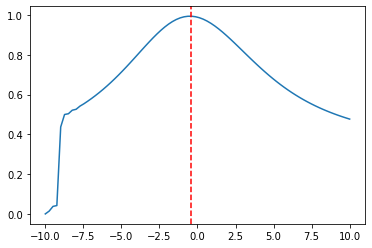

In [221]:
x, y = sp.stats.boxcox_normplot(df.Horsepower, -10, 10) # 이떄에 nan 값이 없어야한다!
plt.plot(x, y);
y2, l = sp.stats.boxcox(df.Horsepower)
plt.axvline(x=l, color='r', ls="--");
print("optimal lambda:", l)

#### Inverse boxcox

만약 y 에 대해서 boxcox 를 진행하였다면, 예측값에 대해서는 다시 inverse 로 돌아가야한다. 그 방법은 아래와 같다.

In [225]:
from scipy.special import boxcox, inv_boxcox
y = boxcox([1, 4, 10], 2.5)
inv_boxcox(y, 2.5)

array([ 1.,  4., 10.])

## Scaling 적용

### train/val/test data Scaling

If you scale the data before train/test split you will get data leakage. Calculating mean/sd of the entire dataset before splitting will result in leakage as the data from each dataset will contain information about the other set of data (through the mean/sd values) and could influence prediction accuracy and overfit.

share  cite  improve this answer  follow 


우리는 모델을 만들때에 scaling 된 데이터로 만들었기 때문에 test set 에 대해서 모델을 평가할 떄에, train set 에 설정했던 scaling 을 그대로 test set 에 적용해준 후 test 를 해야하고, 예측할 떄에도 같은 방법을 써야한다. (TEST SET 에 대한 정보는 아~무것도 알면 안되기 떄문에 TRAIN 에 대해서만! scaling 을 진행하고, 거기서 나온 parameter 들로 test 에 적용해주어야 한다!)

그리고 validation 에 대해서도, validation date 는 test set 과 똑같은 취급을 해줘야 하기 떄문에

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) <br>
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 2/7) <br>
scaler = StandardScaler() <br>
X_train = scaler.fit_transform(X_train) <br>
X_val = scaler.transform(X_val) <br>
X_test = scaler.transform(X_test) <br>
----- 만약 y 도 scaling 한다면 ------ <br>
y_train = scaler.fit_trainsfomr(y_train) <br>
y_val = scaler.trainsform(y_val) <br>
y_test = scaler.transform(y_test) <br>
이렇게  scaling 하는것이 맞다!

In [16]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

iris = load_iris()
iris_data = iris.data
iris_label = iris.target
X_train, X_test, y_train, y_test = train_test_split(iris_data, iris_label,
                                                    test_size=0.2, random_state=2)

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_train) # 학습 데이터에 대해서 fit(), transform() 수행.
scaled_X_train = scaler.transform(X_train)
# 그냥 fit()만 쓰면 정규화 즉, 통계에서 정규분포를 만들게 하기 위해서 𝑥 값에서 평균을 빼고 그 값을 다시 표준편차로 나누어주는 작업

In [18]:
# 테스트 데이터에서는 다시 fit(), transform()이나 fit_transform()을 수행하지 않고 transform만 수행.
# 그러면 train data 에서 쓴 scaling 을 그대로 쓰게 된다! 
scaled_X_test = scaler.transform(X_test)

In [19]:
lr = LogisticRegression()
lr.fit(scaled_X_train, y_train)
pred = lr.predict(scaled_X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9333


fit_transform()을 fit() 과 transform() 함께 수행하는 메소드 입니다. 기존의 fit() 과 transform() 각각을 수행하는 번거로움을 줄여줍니다.  위 코드를 예로 들면

scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)은

=> scaled_X_train = scaler.fit_transform(X_train) 과 같이 한 라인으로 대체 될 수 있습니다. 

하지만 테스트 데이터에 scaled_X_test = scaler.fit_transform(X_test)를 적용해서는 안됩니다. 이를 수행하면 scaler 객체가

기존에 학습 데이터에 fit 했던 기준을 모두 무시하고 다시 테스트 데이터를 기반으로 기준을 적용하기 때문입니다. 

때문에 테스트 데이터에 fit_transform()을 적용해서는 안됩니다.

이런 번거로움을 피하기 위해 학습과 테스트 데이터로 나누기 전에 먼저 Scaling등의 데이터 전처리를 해주는 것이 좋습니다. 아래 코드에

서는 학습과 테스트 데이터로 나누기 전에 Scaling을 적용합니다. fit(), transform()을 순차적으로 써도 좋고 fit_transform()으로 변환

해도 무방합니다.

### y_pred inverse Scaling

우리가 모델링을 하기 전에 y 도 변환했다면, 예측한 데이터는 변환후의 데이터일 것이다.

즉 우리가 원래의 예측치를 뽑아내고 싶다면 이 모델이 예측한 데이터를 원래 scale 로 돌려주어야 한다! 

In [33]:
y_train = np.arange(-3,5).reshape(-1, 1)  
y_train

array([[-3],
       [-2],
       [-1],
       [ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4]])

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_y_train = scaler.fit_transform(y_train) ; scaled_y_train

array([[-1.52752523],
       [-1.09108945],
       [-0.65465367],
       [-0.21821789],
       [ 0.21821789],
       [ 0.65465367],
       [ 1.09108945],
       [ 1.52752523]])

In [43]:
# 위의 변환 정보들은 scaler 객체에 잘 저장이 되어있다. 즉 다시 inverse 로 되돌릴 수 있다는 의미!
print(scaler.mean_,scaler.var_) # mean/var 이 저장되어있는 모습!
y_pred = [[0.6]]
scaler.inverse_transform(y_pred) # 우리의 예측치 0.6 은 원래의 scale 로 되돌리면 1.87 이 된다.

[0.5] [5.25]


array([[1.87477271]])